In [37]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from g_ghost_regnetdrop import g_ghost_regnetx_064

In [38]:
data_folder = os.path.expanduser("~/cifar-10-batches-py")
def load_cifar_10_batch(file):
    with open(os.path.join(data_folder, file), 'rb') as fo:
        cifar_data = pickle.load(fo, encoding='bytes')
    return cifar_data
data_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']
cifar_data_dict = {}
for file in data_files:
    cifar_data_dict.update(load_cifar_10_batch(file))
images = cifar_data_dict[b'data']
labels = cifar_data_dict[b'labels']

In [39]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

images = images.reshape((-1, 3, 32, 32))  # 将图像数据重塑为3x32x32
images = images.transpose((0, 2, 3, 1))  # 调整图像通道顺序
images = [transform(image) for image in images]

In [40]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=256)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=256)

In [41]:
batch_size = 64
train_dataset = TensorDataset(torch.stack(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(torch.stack(X_val), torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_dataset = TensorDataset(torch.stack(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [42]:
model = g_ghost_regnetx_064()  

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [44]:
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print every 25 batches
        if (i + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')
    
    train_accuracy = 100 * correct / total
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    
    # 在验证集上评估模型
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')
    val_accuracies.append(accuracy)

print("Training completed!")

Epoch [1/20], Batch [25/125], Train Loss: 2.5311
Epoch [1/20], Batch [50/125], Train Loss: 2.4133
Epoch [1/20], Batch [75/125], Train Loss: 2.2455
Epoch [1/20], Batch [100/125], Train Loss: 2.3033
Epoch [1/20], Batch [125/125], Train Loss: 2.0112
Epoch [1/20], Validation Loss: 2.2868, Validation Accuracy: 23.88%
Epoch [2/20], Batch [25/125], Train Loss: 2.1947
Epoch [2/20], Batch [50/125], Train Loss: 1.9119
Epoch [2/20], Batch [75/125], Train Loss: 1.8999
Epoch [2/20], Batch [100/125], Train Loss: 1.9563
Epoch [2/20], Batch [125/125], Train Loss: 1.8998
Epoch [2/20], Validation Loss: 1.8935, Validation Accuracy: 30.44%
Epoch [3/20], Batch [25/125], Train Loss: 2.0193
Epoch [3/20], Batch [50/125], Train Loss: 1.7098
Epoch [3/20], Batch [75/125], Train Loss: 1.6060
Epoch [3/20], Batch [100/125], Train Loss: 1.6581
Epoch [3/20], Batch [125/125], Train Loss: 1.7229
Epoch [3/20], Validation Loss: 1.7755, Validation Accuracy: 36.25%
Epoch [4/20], Batch [25/125], Train Loss: 1.9138
Epoch [4/

In [45]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')
torch.save(model.state_dict(), 'cifar10_g_ghost_regnetx.pth')

Test Accuracy: 41.00%


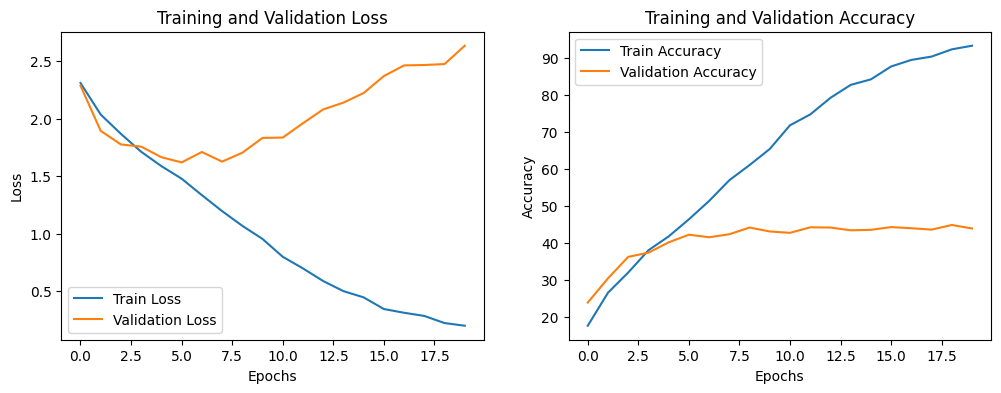

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
#0.65